# Impact Assessment of Data Poisoning Attacks on Collaborative Intrusion Detection Systems using Federated Learning

In [80]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Executive Summary

- **RQ0**: Is the experiment sound?
- **RQ1**: Is the behavior of poisoning attacks predictable?
- **RQ2**: Are there hyperparameter combinations that are beneficial or detrimental in poisoning situation?
- **RQ3**: Can FL recover from poisoning attacks after model aggregation? How long does it take?
- **RQ4**: At what point do poisoning attacks start having an impact? (proportion of poisoned data/clients)
- **RQ5**: Are backdoor attacks realistic in IDS context?
- **RQ6**: Is model similarity enough to detect poisoning attacks? (OPTIONAL)


## RQ0: Is the experiment sound?

Dataset analysis of CICIDS full and sampled. We chose sampled because of the scale of the experiments, but are the results still valid?

## Test methodology
- statistical analysis of the dataset, and comparison of the sampled dataset with the full dataset
  - plot PCA, potentially with colored labels
  - plot correlation matrix
  - plot distribution of labels
- Dispersion analysis (see RQ1) -> interpretability of results

## RQ1: Is the behavior predictable?

A preliminary question to solve is how predictable is the behavior of the attack propagation, given a scenario and a distribution; *ie.*, how scattered are the results at a given point in time, for different seeds.

### Test methodology

Test a set of different seeds on: 5/5, continuous-100. Plot:
1. stats
   - mean
   - standard deviation (envelope mean-std, mean+std)
   - min/max
2. differential analysis 
   - |mean-mean^-1| over time
   - |std-std^-1| over time

**Seeds list**: 1138, 421, 1313, 5555, 6567, 327, 2187, 1977, 501, 3263827

In [81]:
from eiffel.analysis.metrics import choices, display_choices

display_choices(choices("hyperparams/results/"))

Key,Values
distribution,5-5
epochs,"100_10x10, 100_4x25, 100_1x100"
scenario,"continuous-100, late-3"
target,untargeted
batch_size,"128, 32, 512"
datasets,nfv2_sampled_cicids
partitioner,iid
seed,"1313, 327, 1138, 1977, 3263827, 421, 501, 2187, 5555, 6567"


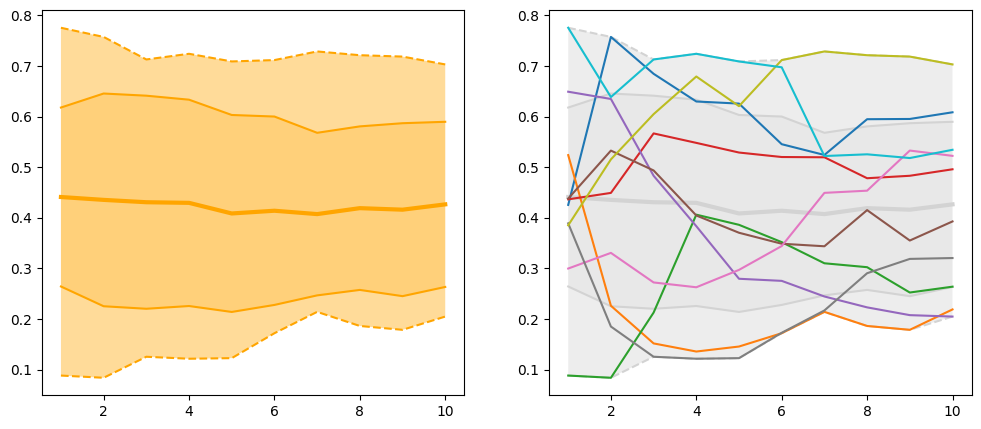

In [88]:
import re
from functools import partial

from eiffel.analysis.metrics import search_metrics
from eiffel.analysis.plot import envelope, load_plotable
from matplotlib import pyplot as plt

fn = partial(load_plotable, typ="distributed", metric="accuracy", with_malicious=False)

plotables_acc = [
    fn(m)
    for m in search_metrics(
        "hyperparams/results/",
        scenario="continuous-100",
        target="untargeted",
        batch_size="512",
        distribution="5-5",
        epochs=".*10x.*",
        datasets=".*cicids",
    )
]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

envelope(plotables_acc, axs[0])
envelope(plotables_acc, axs[1], color="lightgrey")

for plotable in plotables_acc:
    match = re.search(r"seed=(\d+)", plotable.name)
    if match is None:
        raise ValueError(f"Could not find seed in {plotable.name}")
    axs[1].plot(
        range(1, len(plotable.values) + 1),
        plotable.values,
        label=f"seed={match.group(1)}",
    )

There is a surprisingly high amount of dispersion in the results between runs. 
With a simple example (batch size 512, 1 local epoch per round, 50% of attackers), the accuracy varies from ~0.1 to ~0.8 for the **same** round.
Standard deviation is around 0.2, which is a lot considering the scale (between 0 and 1).


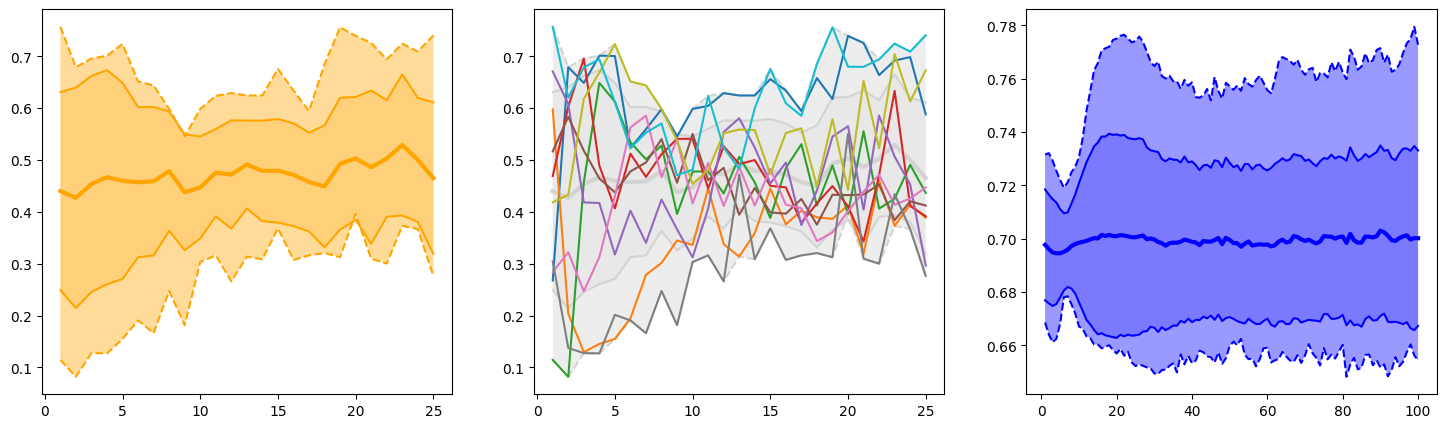

In [90]:
import re
from functools import partial

from eiffel.analysis.metrics import search_metrics
from eiffel.analysis.plot import envelope, load_plotable
from matplotlib import pyplot as plt

fn = partial(load_plotable, typ="distributed", metric="accuracy", with_malicious=False)

plotables_acc = [
    fn(m)
    for m in search_metrics(
        "hyperparams/results/",
        scenario="continuous-100",
        target="untargeted",
        batch_size="128",
        distribution="5-5",
        epochs=".*4x.*",
        datasets=".*cicids",
    )
]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

envelope(plotables_acc, axs[0])
envelope(plotables_acc, axs[1], color="lightgrey")

for plotable in plotables_acc:
    match = re.search(r"seed=(\d+)", plotable.name)
    if match is None:
        raise ValueError(f"Could not find seed in {plotable.name}")
    axs[1].plot(
        range(1, len(plotable.values) + 1),
        plotable.values,
        label=f"seed={match.group(1)}",
    )


fn = partial(load_plotable, typ="distributed", metric="loss", with_malicious=False)
plotables_loss = [
    fn(m)
    for m in search_metrics(
        "hyperparams/results/",
        scenario="continuous-100",
        target="untargeted",
        batch_size="512",
        distribution="5-5",
        epochs=".*1x.*",
        datasets=".*cicids",
    )
]

envelope(plotables_loss, axs[2], color="blue")

The loss seems quite close at the beginning, but diverges quickly, especially the max.
Local models probably fit their data at first, but because of the high amount of attackers, the participants cannot converge to a representative global model, which leads to high variance in the results.

### Conclusions

- A 100% continuous attack perpetrated by 50% of the nodes produces **in average** a 50% detection rate.
- Over ten runs, the results are very sparse: the standard deviation is very high, and the min/max values are very far from the mean.

If the mean value does not change, and neither does the distribution of the results, then it pretty much acts like if the rounds where independent. 
So maybe the ML operations are consequent enough (even for one epoch) that it neglects the impact of the initial conditions on the output.

The results *tend* to confirm the expected hypotheses **in average**. However, it is difficult to predict the behavior of one specific attack.
The results of further analyses (RQ1-4) must be interpreted with this in mind.

**THEREFORE**: While the results of existing defense mechanisms are not to be discarded, such unpredictability might mean that some specific attacks might bypass them if they are not designed to be robust to such variations.



## RQ2: Are there hyperparameter combinations that are beneficial or detrimental in poisoning situation?


### Test methodology
- look at all variations of hyperparameters: `["batch_size", "epochs"]`; learning rate does not need to be tested as Adam (optimizer) has an adaptive learning rate.
	- all curves on one plot
	- average on datasets: `["nfv2/sampled/cicids", "nfv2/sampled/nb15"]`
	- scenario `continuous-100`
- distribution `10-0` and `5-5`
- do it twice for untargeted vs targeted
- do the same for `late-3` to see the impact of previous training

In [85]:
from eiffel.analysis.metrics import choices, display_choices

display_choices(choices("hyperparams/results/"))

Key,Values
distribution,5-5
epochs,"100_10x10, 100_4x25, 100_1x100"
scenario,"continuous-100, late-3"
target,untargeted
batch_size,"128, 32, 512"
datasets,nfv2_sampled_cicids
partitioner,iid
seed,"1313, 327, 1138, 1977, 3263827, 421, 501, 2187, 5555, 6567"


In [86]:
from functools import partial

from eiffel.analysis.metrics import search_metrics
from eiffel.analysis.plot import load_plotable

loadfn = partial(
    load_plotable, typ="distributed", metric="accuracy", with_malicious=False
)

searchfn = partial(
    search_metrics,
    "hyperparams/results/",
    scenario="continuous-100",
    target="untargeted",
    distribution="5-5",
    datasets=".*cicids",
)

NameError: name 'plot' is not defined

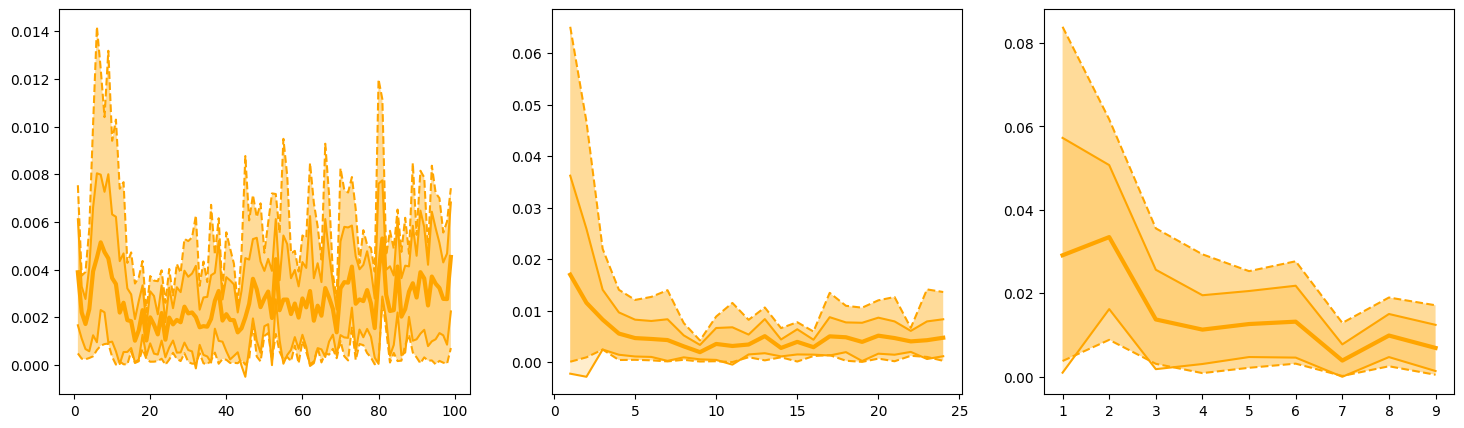

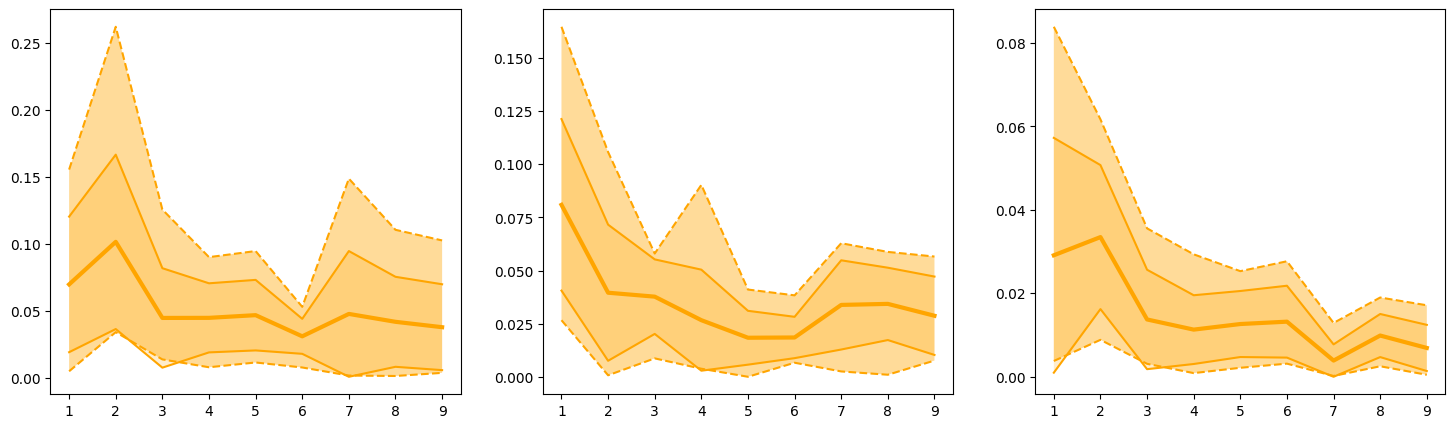

In [84]:
from functools import partial

from eiffel.analysis.metrics import search_metrics
from eiffel.analysis.plot import Plotable, load_plotable

searchfn = partial(
    search_metrics,
    "hyperparams/results/",
    scenario="continuous-100",
    target="untargeted",
    distribution="5-5",
    datasets=".*cicids",
)

loadfn = partial(
    load_plotable, typ="distributed", metric="accuracy", with_malicious=False
)


def diff(plotable: Plotable) -> Plotable:
    return Plotable(
        plotable.name,
        [
            abs(plotable.values[i] - plotable.values[i - 1])
            for i in range(1, len(plotable.values))
        ],
    )


fig, axs = plt.subplots(1, 3, figsize=(18, 5))

acc_diff_1x = [diff(fn(m)) for m in searchfn(batch_size="512", epochs=".*1x.*")]
acc_diff_4x = [diff(fn(m)) for m in searchfn(batch_size="512", epochs=".*4x.*")]
acc_diff_10x = [diff(fn(m)) for m in searchfn(batch_size="512", epochs=".*10x.*")]
envelope(plotables=acc_diff_1x, ax=axs[0])
envelope(plotables=acc_diff_4x, ax=axs[1])
envelope(plotables=acc_diff_10x, ax=axs[2])

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

acc_diff_32 = [diff(fn(m)) for m in searchfn(batch_size="32", epochs=".*10x.*")]
acc_diff_128 = [diff(fn(m)) for m in searchfn(batch_size="128", epochs=".*10x.*")]
acc_diff_512 = [diff(fn(m)) for m in searchfn(batch_size="512", epochs=".*10x.*")]
envelope(plotables=acc_diff_32, ax=axs[0])
envelope(plotables=acc_diff_128, ax=axs[1])
envelope(plotables=acc_diff_512, ax=axs[2])

Over time, the evolution in mean over time gets smaller, which means that the model tends to converge to a stable state.
Overall, the bigger the batch size and the number of local epochs, the more predictable the behavior is.
This is quite expected in terms of stability, and seems in phase with results from the literature.

### Conclusions

## RQ3: Can FL recover from poisoning attacks after model aggregation? How long does it take?
- focus on scenario `redemption-3`
	- all distributions: `["10-0","9-1","7-3","5-5","3-7"]`
	- targeted vs untargeted
	- one hyperparameter combination (default `512` / `10-10`, adapt with results of RQ1)

## RQ4: At what point do poisoning attacks start having an impact?
- focus on one hyperparameter combination (default `512` / `10-10`, adapt with results of RQ1)
	- average on datasets: `["nfv2/sampled/cicids", "nfv2/sampled/nb15"]`
- for each `["continuous-10","continuous-30","continuous-60","continuous-100"]` 
	- display all distributions on one plot (`["10-0","9-1","7-3","5-5","3-7"]`)

## RQ5: Are backdoor attacks realistic in IDS context?

Note that this does not refer to the backdoor attacks as often defined in ML, but more as backdoors applied to NIDS, where the attacker makes it so that the IDS does not detect a specific attack or attack pattern.

## Test methodology

- focus on one hyperparameter combination (default `512` / `10-10`, adapt with results of RQ1)
- focus on targeted attacks (test all targets)
- look especially at the attack success rate (see def in Trust-FIDS)

**Note**: some results must be gathered from other runs (*eg.*, class "dos" has been removed here since it's already available in "attacks/").

## RQ6: Is model similarity enough to detect poisoning attacks? (OPTIONAL)

Optionally, the assessment paper can be used to highlight how poisoning can be used to highlight how model distance is not enough to express poisoning whereas cross evaluation can:
- setup two IID clients from the same dataset
- drop classes so that similarity is low
- keep one common attack class that is partially poisoned by one
- show the results of the aggregation (impact on perf), with the similarity and eval score